In [3]:
import networkx as nx
# import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import scipy as sp
%matplotlib inline

# some useful functions:
- random_walk : to compute random walk of one particle.
- time_first_particle : to compute the time of the first particle to reach the final node.
- time_avg_particle : to check the time for the avg particle to reach the final node (4.6, as in the first exercise).
- bin_particles : each simulation has a different length, how can we compare them? With this function.
- particles_in_nodes_local_poisson : from the point of view of the nodes.
- simulate : wrapper to comfortably repeat the experiments for more than one time.
- plot_particles_in_nodes : compute average across simulations, and display the results.

### Those are to test different approaches
They are not used in the resolution of the exercise, but you can find the results and confront between them in the Appendix.
- particles_in_nodes_global_poisson : use the hint suggested in the assignment, but slightly modified.
- particles_in_nodes_local_poisson_modified : a simplified version of 'particles_in_nodes_local_poisson'.
- particles_in_nodes_global_poisson_modified : This is strictly following theory.

In [4]:
def random_walk(P, rates, start_node, end_node):
    """Simulate a random walk on the graph, starting from start_node,
    and ending when the particle reaches end_node.

    This is done by sampling from an exponential distribution (for each node),
    the time spent in each node, and then sampling from the transition probabilities
    of the P matrix, to choose the next node.

    Args:
        P (np.array): matrix of transition probabilities.
        rates (np.array): array of rates of each node.
        start_node (int): starting node index.
        end_node (int): ending node index.

    Returns:
        time (float): time spent in the walk.
    """
    num_nodes = P.shape[0]
    current_node = start_node
    time = 0
    while True:
        # add the time spent in the current node
        time += np.random.exponential(1/rates[current_node])
        # choose the next node
        next_node = np.random.choice(num_nodes, p=P[current_node])
        current_node = next_node

        # if the particle reaches the end node, stop the walk
        if current_node == end_node:
            # add the time of the walk
            return time

def time_first_particle(P, rates, start_node, end_node, num_particles=100):
    """If we simulate a random walk on the graph, using n particles, 
    what is the expected time for the first particle to reach end_node, 
    starting from start_node?
    
    Returns:
        min_time (float): The expected time for the first particle to reach end_node.
    """
    # compute 100 times
    times = [random_walk(P, rates, start_node, end_node)
                for i in range(num_particles)]
    # convert to numpy array and find the minimum
    min_time = np.array(times).min()
    # and return the minimum
    return min_time

def time_avg_particle(P, rates, start_node, end_node, num_particles=100):
    """If we simulate a random walk on the graph, using n particles, 
    what is the expected time for a particle to reach end_node, 
    starting from start_node?
    
    Returns
        avg_time (float): The expected time for a particle to reach end_node.
    """
    # compute 100 times
    times = [random_walk(P, rates, start_node, end_node)
                for i in range(num_particles)]
    # convert to numpy array and find the minimum
    avg_time = np.array(times).mean()
    # and return the minimum
    return avg_time

def bin_particles(particles, time, time_range):
    """Bin the particles according to the time range.
    The returned array is of the same length of time_range.

    This function is used to have the same number of time steps in each simulation,
    even if originally, being a stochastic process, the number of time steps is different.

    Args:
        particles (np.array): array of particles in each node at each time step
        time (np.array): array of time at each time step
        time_range (np.array): array of time range

    Returns:
        particles (np.array): array of particles in each node at each time step.
    """
    particles = np.array(particles)
    # take indices of time according to time_range
    indices = np.digitize(time_range, time)

    particles = particles[indices-1]
    return particles

def particles_in_nodes_local_poisson(P, rates, start_node, num_particles=100, stop_time=60):
    """Simulate the number of particles in each node.

    At the beginning:
    - We calculate all the ticking times for each node.

    At each time step:
    1. We choose the node with the minimum ticking time.
    2. We choose the node in which the particle will go.
    3. We update the particles in those two nodes.
    4. We update the corresponding ticking times of the two nodes.
    5. We update the ticking times of all the other nodes, by subtracting the minimum ticking time.

    The reason for that is that the ticking times are independent to each other,
    so when a node ticks, the other nodes don't know, and wait for their ticks independently.
    For them the time continues to flow as before.

    Args:
        P (np.array): matrix of transition probabilities
        rates (np.array): array of rates of each node
        start_node (int): starting node
        num_particles (int): number of particles. Defaults to 100.
        stop_time (int, optional): stopping time. Defaults to 60.

    Returns:
        particles (np.array): array of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of each time step
    """
    # initialize particles and time
    particles = np.zeros(P.shape[0], dtype=int)
    time = 0
    particles[start_node] = num_particles
    # initialize the results
    acc_particles = [particles.copy()]
    acc_time = [time]
    # stay time = scale
    stay_time = 1/rates
    # Initial tick time
    tick_times = np.random.exponential(stay_time/particles) # 1/(omega*particles)

    while time < stop_time:
        # Find the index of the minimum
        ticking_node = np.argmin(tick_times)
        # Find the minimum
        min_time = tick_times[ticking_node]
        # Update time
        time += min_time
        # Choose the next node
        chosen_node = np.random.choice(len(particles), p=P[ticking_node])
        # Update particles
        particles[ticking_node] -= 1
        particles[chosen_node] += 1
        # Update tick time for all nodes
        tick_times = tick_times - min_time
        # Update for ticking_node (reset)
        tick_times[ticking_node] = np.random.exponential(stay_time[ticking_node]/particles[ticking_node])
        # Update for chosen_node:
        # The new tick time is the minimum between the previous tick time and
        # the time to stay in the node for the new particle.
        tick_times[chosen_node] = min(
            np.random.exponential(stay_time[chosen_node]),
            tick_times[chosen_node])
        # store the results
        acc_particles.append(particles.copy())
        acc_time.append(time)
    return particles, acc_particles, acc_time


def particles_in_nodes_global_poisson(P, rates, start_node, num_particles=100, stop_time=60):
    """Simulate the number of particles in each node, using a global Poisson process.

    Here we do some personal assumptions:
    1. The ticking time of each node is given by a global Poisson process, with rate = sum(rates).
    This is possible because the ticking times are independent, Poisson(sum(rates)) is the same as min(Poisson(rates)). 
    The first is to have one global clock, the second is to have one clock for each node.

    2. The probability of tick for each node is given by the number of particles in the node, weighted by the rate.
    So, after computing the tick_time, we choose the node that ticks, with probability = rate*particles normalized to sum to 1.

    3. Finally, the probability of choosing the next node is given by the transition probabilities of P.
    The probability is given by P = diag(rates)^-1 @ matrix_of_rates. (the matrix of rates normalized), and not by P_bar.
    This is possible thanks to assumption 1 and 2.

    Exampe:\\
    At the the beginning, with 100 particles in node 'o', the global rate would be 100 * rate_o,
    But after some time, we could have this configuration: [22, 14, 31, 16, 17] in the nodes.
    The global rate in this configuration should be sum(rates * [22, 14, 31, 16, 17]), 
    which is different!

    Args:
        P (np.array): matrix of transition probabilities
        rates (np.array): array of rates of each node
        start_node (int): starting node
        num_particles (int): number of particles
        stop_time (int, optional): stopping time. Defaults to 60.

    Returns:
        particles (np.array): array of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of each time step
    """
    # initialize particles and time
    particles = np.zeros(P.shape[0], dtype=int)
    time = 0
    particles[start_node] = num_particles
    # Initial probability of tick for each node:
    # each node ticks at a different rate, to find the probability of tick:
    # 1. Multiply the tick rate for the number of particles in the node.
    # 2. Normalize to sum to 1, to have a probability distribution.
    tick_probs = lambda r, p : r*p / (r*p).sum()
    # global rate: sum of the rates of the nodes * number of particles
    global_rate = lambda r, p : (r*p).sum()
    # initialize the results
    acc_particles = [particles.copy()]
    acc_time = [time]
    
    while time < stop_time:
        # update the tick time, and the current time
        tick_time = np.random.exponential(1/global_rate(rates, particles))
        time += tick_time
        # Find the index of the ticking node
        ticking_node = np.random.choice(P.shape[0], p=tick_probs(rates, particles))       
        # Choose the next node
        chosen_node = np.random.choice(len(particles), p=P[ticking_node])
        # Update particles
        particles[ticking_node] -= 1
        particles[chosen_node] += 1
        # store the results
        acc_particles.append(particles.copy())
        acc_time.append(time)

    return particles, acc_particles, acc_time

def particles_in_nodes_local_poisson_modified(P, rates, start_node, num_particles=100, stop_time=60):
    """Simulate the number of particles in each node.

    This version is a modified version of particles_in_nodes_local_poisson, 
    here we calculate tick times for all nodes after every tick, 
    instead of calculating them all once at the beginning, 
    and then update just the ticking node and the chosen node as described before.

    This, from a mathematical point of view, is the same as the previous version.
    In fact, poisson clocks are invariant to time: P(N(t+s)|N(t)=0) = P(N(s)).

    Args:
        P (np.array): matrix of transition probabilities
        stay_time (np.array): array of stay times
        num_particles (int): number of particles
        start_node (int): starting node
        stop_time (int, optional): stopping time. Defaults to 60.

    Returns:
        particles (np.array): array of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of each time step
    """
    # initialize particles and time
    particles = np.zeros(P.shape[0], dtype=int)
    time = 0
    particles[start_node] = num_particles
    # initialize the results
    acc_particles = [particles.copy()]
    acc_time = [time]
    # stay time = scale
    stay_time = 1/rates    
    
    while time < stop_time:
        # In this modified version, calculate tick times for each node after every tick
        tick_times = np.random.exponential(stay_time/particles) # 1/(omega*particles)
        # Find the index of the minimum
        ticking_node = np.argmin(tick_times)
        # Find the minimum
        min_time = tick_times[ticking_node]
        # Update time
        time += min_time
        # Choose the next node
        chosen_node = np.random.choice(len(particles), p=P[ticking_node])
        # Update particles
        particles[ticking_node] -= 1
        particles[chosen_node] += 1
        # store the results
        acc_particles.append(particles.copy())
        acc_time.append(time)

    return particles, acc_particles, acc_time

def particles_in_nodes_global_poisson_modified(t_rate, start_node, num_particles=100, stop_time=60):
    """Simulate the number of particles in each node, using a global Poisson process.

    This version is very similar to the one suggested by professors:
    1. We use a global poisson process with rate 100, to simulate the ticks. (This is a approximation of the real rate).
    2. We select the node that ticks, considering the amount of particles in each node as probabilities.
    3. We select the node chosen by the particle, considering the transition probabilities of P_bar.

    Args:
        t_rate (np.array): matrix of transition rates
        start_node (int): starting node index
        num_particles (int, optional): number of particles in the system. Defaults to 100.
        stop_time (int, optional): stopping time of simulation. Defaults to 60.

    Returns:
        particles (np.array): array of particles in each node at the end of the simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of each time step
    """
    # calculate rates
    rates = t_rate.sum(axis=1)
    # calculate the max rate
    max_rate = rates.max()
    # calculate the probability transition matrix: P_bar
    P_bar = t_rate/max_rate
    P_bar += np.eye(P_bar.shape[0]) - np.diag(P_bar.sum(axis=1))
    # initialize particles in each node
    particles = np.zeros(P_bar.shape[0], dtype=int)
    particles[start_node] = num_particles
    # initialize the results and time
    time = 0
    acc_time = [time]
    acc_particles = [particles.copy()]
    # calculate the ticking prob for each node:
    # this time is only given by the nummber of particles in the node.
    tick_probs = lambda p : p / p.sum()

    while time < stop_time:
        # this is the global poisson clock, with rate = num_particles
        t_next = np.random.exponential(1/num_particles)
        time += t_next
        # randomly choose the starting node
        ticking_node = np.random.choice(P_bar.shape[0], p=tick_probs(particles))
        # choose the next node
        chosen_node = np.random.choice(P_bar.shape[0], p=P_bar[ticking_node])
        # update particles
        particles[ticking_node] -= 1
        particles[chosen_node] += 1
        # store the results
        acc_particles.append(particles.copy())
        acc_time.append(time)

    return particles, acc_particles, acc_time

def simulate(num_simulations, config, function):
    """run simulations.

    Args:
        num_simulations (int): number of simulations
        config (dict): configuration
        function (function): function to simulate

    Returns:
        particles (list): list of particles in each node at the end of each simulation
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of time at each time step
    """
    # initialize the results
    particles = []
    acc_particles = []
    acc_time = []
    for _ in tqdm(range(num_simulations)):
        # simulate the particles
        ps, acc_ps, acc_tm = function(**config)
        # store the results
        particles.append(ps)
        acc_particles.append(acc_ps)
        acc_time.append(acc_tm)
    return particles, acc_particles, acc_time  
    

def plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=60, num_bins=1000):
    """
    Plot the average number of particles in each node over time.

    The average is computed across simulations, in order to have a more stable result.
    To do so, we need the same number of time steps in each simulation, 
    so we bin the particles according to the time range, using the function bin_particles.

    Args:
        nodes (list): list of nodes
        acc_particles (list): list of particles in each node at each time step
        acc_time (list): list of each time step
        stop_time (int, optional): stopping time. Defaults to 60.
        num_bins (int, optional): number of bins. Defaults to 1000.
    """
    time_range = np.linspace(0, stop_time, num_bins)

    particles = [bin_particles(p, t, time_range) for p, t in zip(acc_particles, acc_time)]
    particles = np.array(particles).mean(axis=0)

    plt.figure(figsize=(10, 6))
    for i, node in enumerate(nodes):
        plt.plot(time_range, particles[:, i], label=node)
    plt.xlabel('Time')
    plt.ylabel('Number of Particles')
    plt.title('Number of Particles in Each Node')
    plt.legend()
    plt.show()

# Data of exercise

In [5]:
# data:

# Transition matrix
t_rate = np.array([
        [0, 2/5, 1/5, 0, 0],
        [0, 0, 3/4, 1/4, 0],
        [1/2, 0, 0, 1/3, 0],
        [0, 0, 1/3, 0, 2/3],
        [0, 1/3, 0, 1/3, 0]
    ])

# node names
nodes = ["o", "a", "b", "c", "d"]

# mapping from node names to indices
node_indices = dict(zip(nodes, range(len(nodes))))

# Create  the graph

{('o', 'a'): 0.4,
 ('o', 'b'): 0.2,
 ('a', 'b'): 0.75,
 ('a', 'c'): 0.25,
 ('b', 'o'): 0.5,
 ('b', 'c'): 0.3333333333333333,
 ('c', 'b'): 0.3333333333333333,
 ('c', 'd'): 0.6666666666666666,
 ('d', 'a'): 0.3333333333333333,
 ('d', 'c'): 0.3333333333333333}

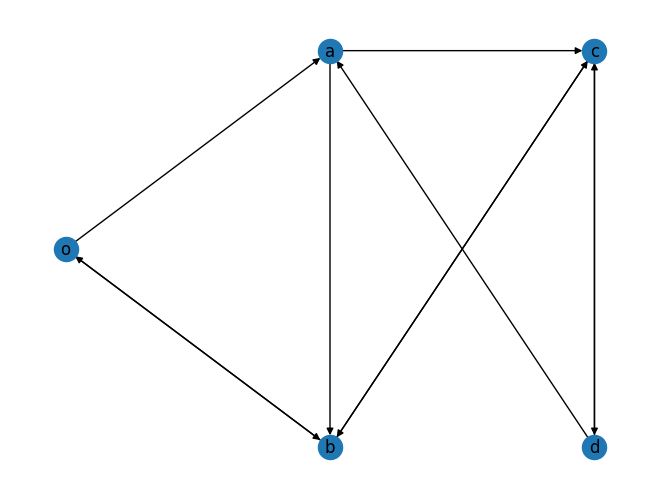

In [6]:
# create graph
G = nx.DiGraph(t_rate)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),nodes)))

# draw a graph with multiple edges
pos = {'o': (0,0), 'a': (1,1), 'b': (1,-1), 'c': (2,1), 'd': (2,-1)}
nx.draw(G, pos, with_labels=True)

edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels

# Calculate omega and P
Needed almost everywhere

In [7]:
# calculate omega
omega = t_rate.sum(axis=1)

# calculate P
P = np.linalg.inv(np.diag(omega)) @ t_rate

# Particle perspective:
- If 100 particles all start in node b, what is the average time for a particle to return to node b?
- How does this compare to the answer in Problem 1, why?

100%|██████████| 10000/10000 [00:01<00:00, 9952.45it/s]


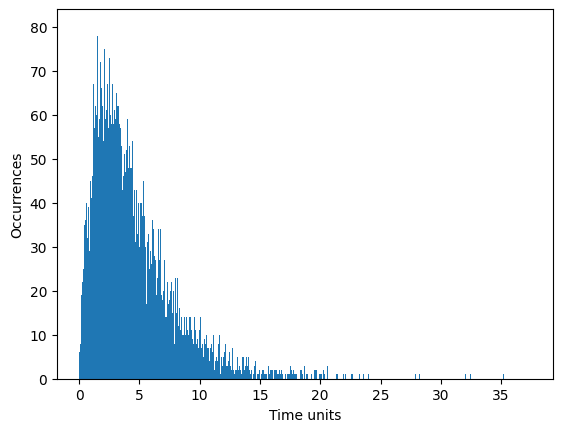

In [13]:
# with this cell we are plotting the distribution of the particles return time.

start_node = node_indices["b"]
end_node = node_indices["b"]

t=[]
for i in tqdm(range(10000)):
    t.append(random_walk(P, omega, start_node, end_node))
plt.hist(t, bins=1000)
# plt.title('Distribution of the return time of 10k particles over 1k bins')
plt.xlabel('Time units')
plt.ylabel('Occurrences')
plt.show()

100%|██████████| 10000/10000 [01:40<00:00, 99.04it/s]


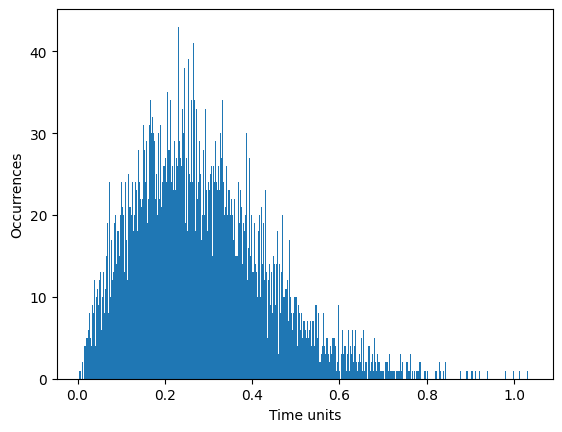

In [12]:
# with this cell we are plotting the distribution of return times of the first particles returning.

first_t=[]
for i in tqdm(range(10000)):
    first_t.append(time_first_particle(P, omega, start_node, end_node))

plt.hist(first_t, bins=1000)
# plt.title('Distribution of the return time of first arrivals of 10k simulations over 1k bins')
plt.xlabel('Time units')
plt.ylabel('Occurrences')
plt.show()

In [10]:
# From the point of view of particles:
# Calculate the time for the first particle, 
# to have a stable result, use n simulations.

# initialize start and end node
start_node = node_indices["b"]
end_node = node_indices["b"]

# calculate the average time for the first particle of 100 to reach end_node
num_simulations = 1000

# min time of each simulation
times = [time_first_particle(P, omega, start_node, end_node)
         for _ in tqdm(range(num_simulations))]

# convert to numpy array and find the avg
avg_time = np.array(times).mean()

print(f"The average time for the first particle to reach {nodes[end_node]} is {avg_time:.5f}.")

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:10<00:00, 92.45it/s]

The average time for the first particle to reach b is 0.28626.


In [11]:
# calculate instead the average time for a particle to reach end_node, 4.6, as it should be (this was already done in Exercise 1)

times = [time_avg_particle(P, omega, start_node, end_node) 
         for _ in tqdm(range(num_simulations))]
avg_time = np.array(times).mean()

print(f"The average time for a particle to reach {nodes[end_node]} is {avg_time:.5f}.")


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:09<00:00, 102.95it/s]

The average time for a particle to reach b is 4.59975.


# Node perspective:
- If 100 particles start in node o, and the system is simulated for 60 time units, what is the average number of particles in the different nodes at the end of the simulation?

100%|██████████| 1000/1000 [06:36<00:00,  2.52it/s]


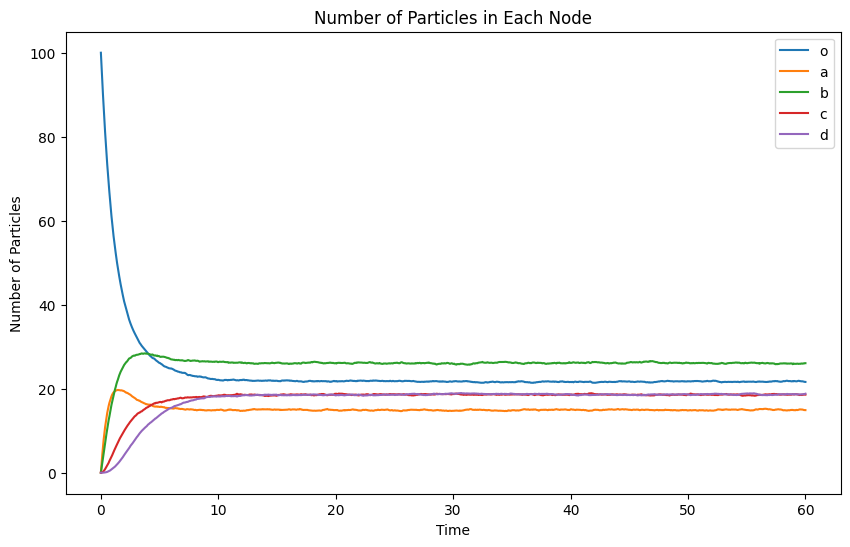

Average particles in each node after 60 time units:
o: 21.585
a: 14.926
b: 26.075
c: 18.597
d: 18.817


In [77]:
# From the point of view of nodes:
# in order to calculate the average number of particles in each node over time,
# we need to simulate the particles for a certain number of simulations, we choose 1000.

# the one simulation plot is done by putting num_simulations to 1.

# simulate for n times
num_simulations = 1000

# create config for particles_in_nodes_local_poisson
config = {
    "P": P,
    "rates": omega,
    "start_node": node_indices["o"],
    "num_particles": 100,
    "stop_time": 60
}

# simulate for n times
with np.errstate(divide='ignore', invalid='ignore'):
     particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_local_poisson)

# plot the results
plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=config["stop_time"])
avg1 = np.array(particles).mean(axis=0)
# calculate the average of particles in each node at the end of all simulations
# and print it
print(f"Average particles in each node after {config['stop_time']} time units:")
for node, avg_particle in zip(nodes, avg1):
    print(f"{node}: {avg_particle}")

# Comparison with pi_bar: $\bar{\pi}$
Compare the simulation result in the first point above with the stationary distribution of the **continuous-time random walk $\bar{\pi}$**, calculated using linear algebra.

### Why these calcs
In this context, considering the **eigenvalue equal to 0** is important because it corresponds to the **stationary distribution of the continuous-time random walk** on the graph. The **kernel associated** with the eigenvalue 0 represents the **eigenvector** that characterizes the **stationary** distribution. By finding this eigenvector, we can calculate the stationary distribution, which provides insights into the long-term behavior of the random walk on the graph.

pi_bar	our mean   our std
0.2174	0.2158  +- 0.0416
0.1491	0.1493  +- 0.0364
0.2609	0.2607  +- 0.0459
0.1863	0.1860  +- 0.0407
0.1863	0.1882  +- 0.0401

As we can see, the difference is very small, so we can say that the results are consistent.


/tmp/ipykernel_14739/2913694059.py:41: UserWarning: Legend does not support handles for Text instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


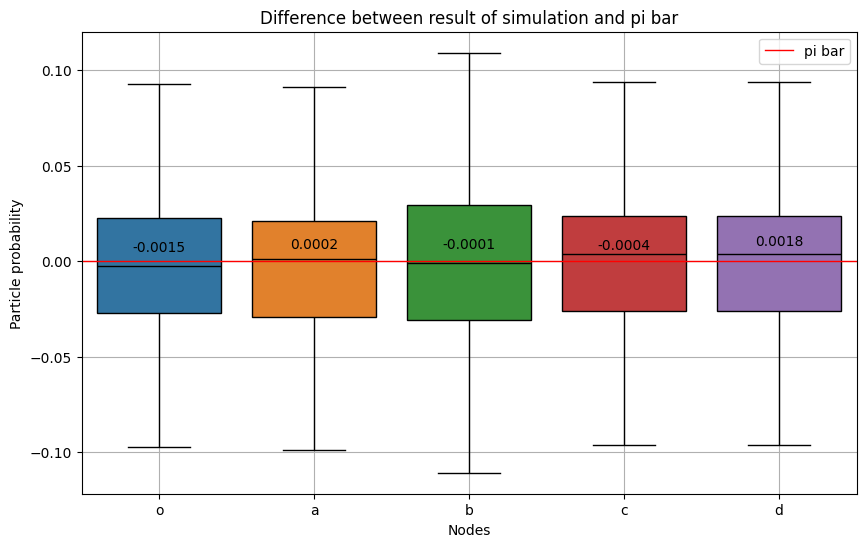

In [226]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate pi_bar again, from a theoretical point of view:
# It is the stationary distribution of the continuous-time random walk.
# start from the graph Laplacian
W = nx.adjacency_matrix(G).todense()
L = np.diag(W.sum(axis=1)) - W

# find the kernel, consider only the eigenvalue 0
eigvals, eigvecs = np.linalg.eig(L.T)
kernel = eigvecs[:, np.isclose(eigvals, 0)].real
pi_bar = (kernel/np.sum(kernel)).flatten()

# number of particles
num_particles = 100
particles = np.load(particles)/num_particles
particles_mean = particles.mean(axis=0)
particles_std = particles.std(axis=0)

# print the results
print(f"pi_bar\tour mean   our std")
for p, m, s in zip(pi_bar, particles_mean, particles_std):
    print(f"{p:.4f}\t{m:.4f}  +- {s:.4f}")

print("\nAs we can see, the difference is very small, so we can say that the results are consistent.")

# Create the stripplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(particles-pi_bar, columns=nodes), showfliers=False, linecolor='black')  # Hiding outliers
# draw a line y=0
plt.axhline(0, ls='-', color='red', label='pi bar', linewidth=1)

# write the numbers of difference in the graph
for i, n in enumerate(particles_mean-pi_bar):
    plt.text(i, n + 0.005, f"{n:.4f}", horizontalalignment='center', verticalalignment='bottom')

# Customize the plot
plt.title("Difference between result of simulation and pi bar")
plt.xlabel("Nodes")
plt.ylabel("Particle probability")
plt.legend()
plt.grid()
plt.show()

# Appendix

Here you can find some confrontations and plottings: we analyzed the difference between the three possible functions (more infos in the description of the functions):
- global poisson
- loca poisson
- local poisson modified
- global poisson modified

We tried to check:
1. The correctness of final result for each method, once stationarity is reached.
2. The Correctness of behaviour in time, here we plotted the results, using 1000 simulations and 15 time units, enough to reach stationarity, and see all the evolution. 
3. The efficency: the time to compute 100 simulations for each method.

### Conclusion
In the scenario below:
- start_node is "o".
- 100 particles.
- 15 seconds.
- matrix of rates: t_rate

All the methods give the **same exact result**. 

We can conclude they have the same behaviour, so we kept these to be checked by professors, and used, when possible the one less time consuming.

Is is important to notice two things.
1. In the following exercise (3) they would not behave the same.
2. There is another version faster which we didn't implemented here. The main difference is in the choose of `np.random` as library, which is slow, but very easy to read and use.

  0%|          | 1/1000 [00:00<03:47,  4.39it/s]

100%|██████████| 1000/1000 [01:29<00:00, 11.14it/s]


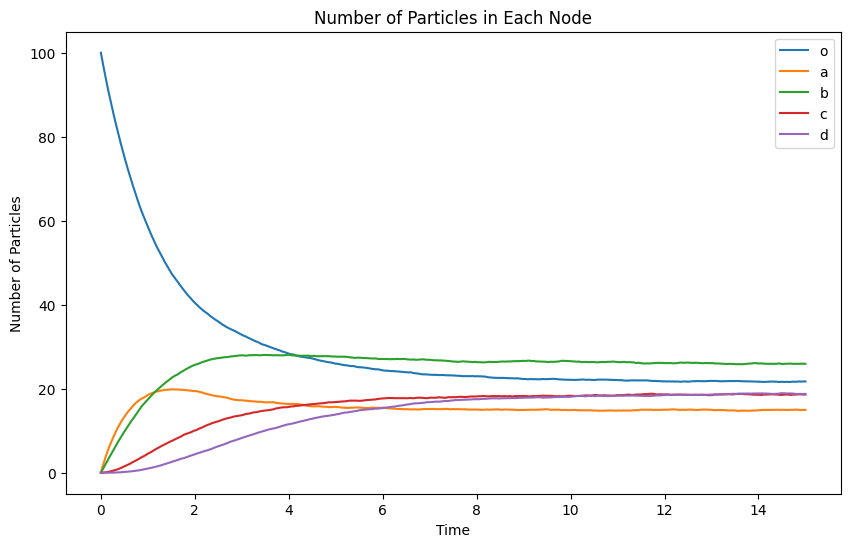

100%|██████████| 1000/1000 [02:24<00:00,  6.93it/s]


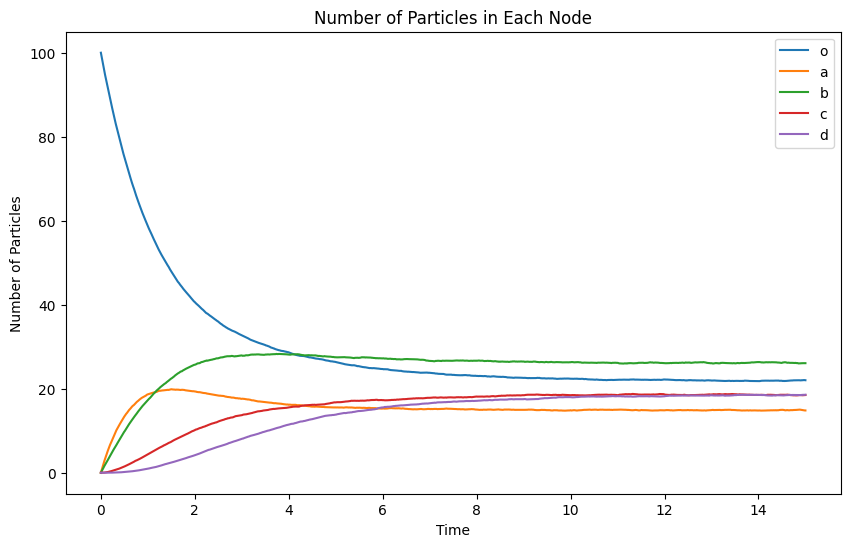

100%|██████████| 1000/1000 [01:58<00:00,  8.42it/s]


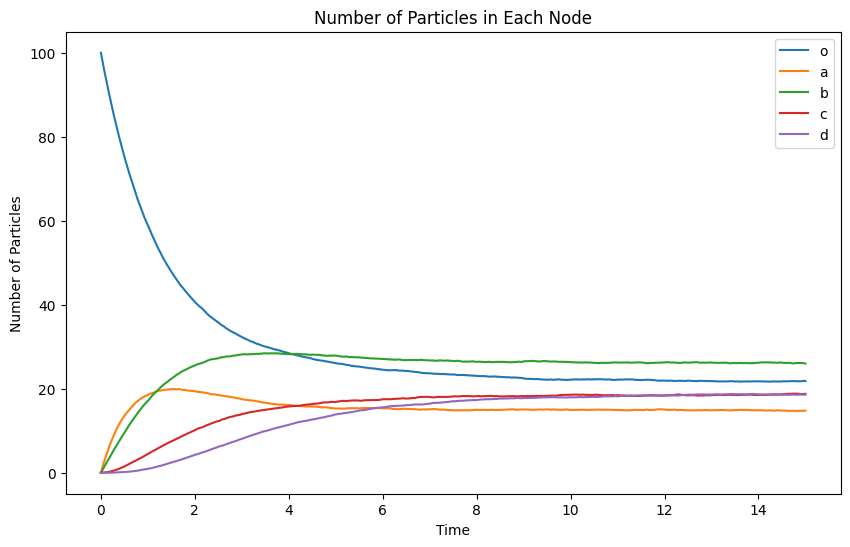

100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


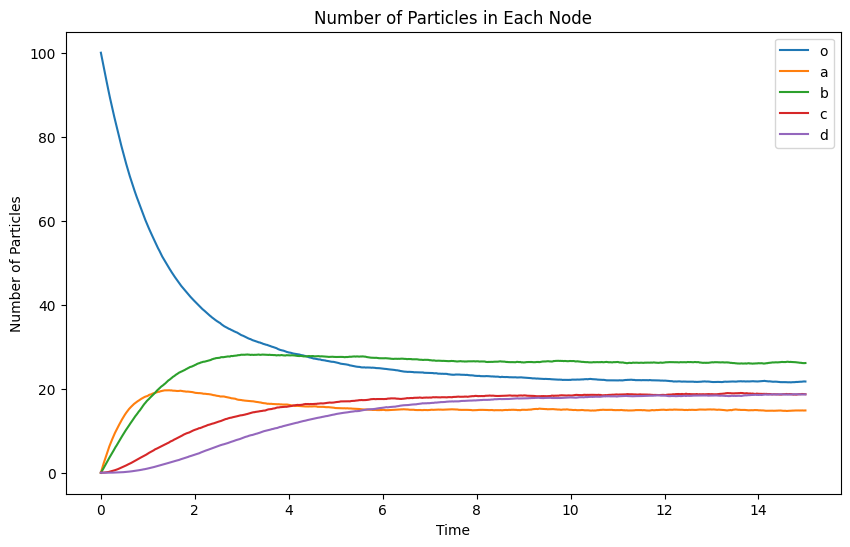

In [ ]:
# simulate for n times
num_simulations = 1000

# create config for particles_in_nodes_local_poisson
config = {
    "P": P,
    "rates": omega,
    "start_node": node_indices["o"],
    "num_particles": 100,
    "stop_time": 15
}
# simulate for n times with particles_in_nodes_local_poisson
with np.errstate(divide='ignore', invalid='ignore'):
    particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_local_poisson)
plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=config["stop_time"])
avg1 = np.array(particles).mean(axis=0)

# implement the same as before, but with gloabl Poisson process
with np.errstate(divide='ignore', invalid='ignore'):
     particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_global_poisson)
plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=config["stop_time"])
avg2 = np.array(particles).mean(axis=0)

# simulate with the function: particles_in_nodes_modified
with np.errstate(divide='ignore', invalid='ignore'):
    particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_local_poisson_modified)
plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=config["stop_time"])
avg3 = np.array(particles).mean(axis=0)

config = {
    "t_rate": t_rate,
    "start_node": node_indices["o"],
    "num_particles": 100,
    "stop_time": 15
}
# simulate with the function: particles_in_nodes_global_poisson_modified
with np.errstate(divide='ignore', invalid='ignore'):
    particles, acc_particles, acc_time = simulate(num_simulations, config, particles_in_nodes_global_poisson_modified)
plot_particles_in_nodes(nodes, acc_particles, acc_time, stop_time=config["stop_time"])
avg4 = np.array(particles).mean(axis=0)

The confront between pi_bar, avg1, avg2, avg3, after 15 time units:
node	pi_bar	avg1	avg2	avg3	avg4
o	0.21739	0.21720	0.22024	0.21798	0.21696
a	0.14907	0.14937	0.14816	0.14799	0.14863
b	0.26087	0.25922	0.26091	0.26045	0.26108
c	0.18634	0.18652	0.18525	0.18775	0.18695
d	0.18634	0.18769	0.18544	0.18583	0.18638


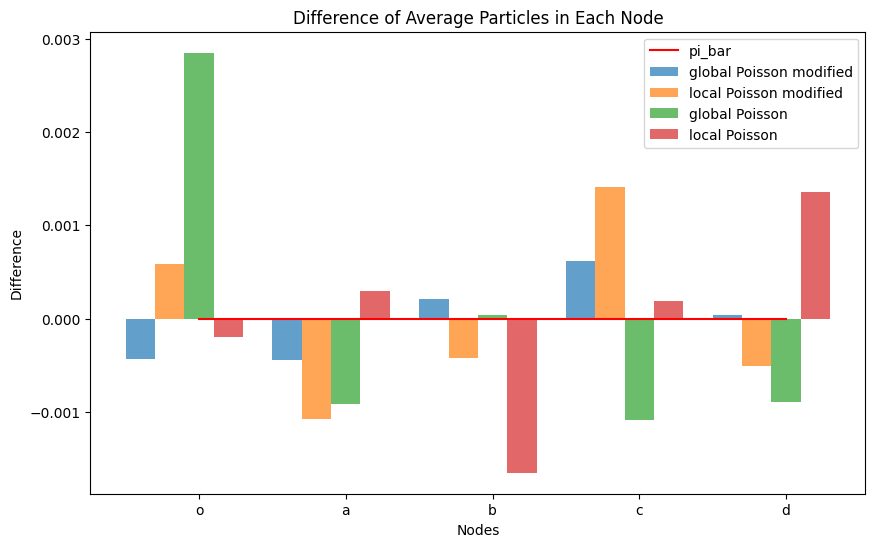

The difference between the results is very small, so we can say that the results are consistent.


In [ ]:
# Confront the stationary results:
# number of particles
num_particles = 100

avg1_norm = avg1 / num_particles
avg2_norm = avg2 / num_particles
avg3_norm = avg3 / num_particles
avg4_norm = avg4 / num_particles

print(f"The confront between pi_bar, avg1, avg2, avg3, after {config['stop_time']} time units:")
print("node\tpi_bar\tavg1\tavg2\tavg3\tavg4")
for node, p, a1, a2, a3, a4 in zip(nodes, pi_bar, avg1_norm, avg2_norm, avg3_norm, avg4_norm):
    print(f"{node}\t{p:.5f}\t{a1:.5f}\t{a2:.5f}\t{a3:.5f}\t{a4:.5f}")

# plot as before but this time, respect to pi_bar
plt.figure(figsize=(10, 6))
bar_width = 0.2

plt.bar(np.arange(len(nodes))-bar_width*2, avg4_norm-pi_bar, label="global Poisson modified", alpha=0.7, width=bar_width)
plt.bar(np.arange(len(nodes))-bar_width, avg3_norm-pi_bar, label="local Poisson modified", alpha=0.7, width=bar_width)
plt.bar(np.arange(len(nodes)), avg2_norm-pi_bar, label="global Poisson", alpha=0.7, width=bar_width)
plt.bar(np.arange(len(nodes))+bar_width, avg1_norm-pi_bar, label="local Poisson", alpha=0.7, width=bar_width)
plt.plot(np.arange(len(nodes)), np.zeros(len(nodes)), label="pi_bar", color="red")
plt.xticks(np.arange(5), nodes)
plt.xlabel('Nodes')
plt.ylabel('Difference')
plt.title('Difference of Average Particles in Each Node')
plt.legend()
plt.show()

print("The difference between the results is very small, so we can say that the results are consistent.")

local Poisson:		8.98651
global Poisson:		17.22277
local Poisson modified:	12.65648
global Poisson modified:	12.83241


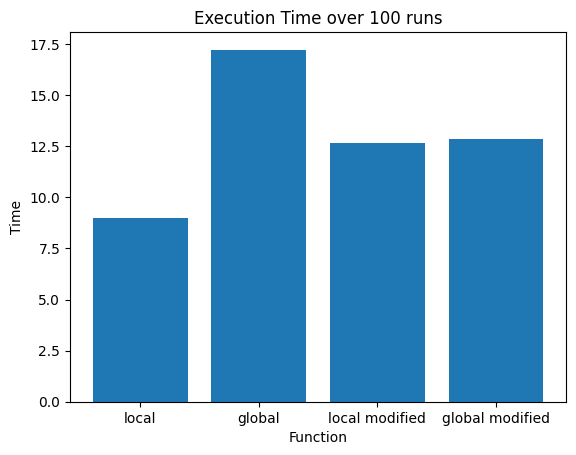

In [17]:
import timeit

# number of run
number = 100

# create config for first three functions
config = {
    "P": P,
    "rates": omega,
    "start_node": node_indices["o"],
    "num_particles": 100,
    "stop_time": 15
}

# config for the 4th function
config1 = {
    "t_rate": t_rate,
    "start_node": node_indices["o"],
    "num_particles": 100,
    "stop_time": 15
}

# create wrapper functions
func1 = lambda : particles_in_nodes_local_poisson(**config)
func2 = lambda : particles_in_nodes_global_poisson(**config)
func3 = lambda : particles_in_nodes_local_poisson_modified(**config)
func4 = lambda : particles_in_nodes_global_poisson_modified(**config1)

# ignore numpy runtimewarning and execute the functions
with np.errstate(divide='ignore', invalid='ignore'):
    local_poisson_time = timeit.timeit(func1, number=number)
    global_poisson_time = timeit.timeit(func2, number=number)
    local_poisson_modified_time = timeit.timeit(func3, number=number)

with np.errstate(divide='ignore', invalid='ignore'):
    global_poisson_modified_time = timeit.timeit(func4, number=number)
    
# print the results
print(f"local Poisson:\t\t{local_poisson_time:.5f}")
print(f"global Poisson:\t\t{global_poisson_time:.5f}")
print(f"local Poisson modified:\t{local_poisson_modified_time:.5f}")
print(f"global Poisson modified:\t{global_poisson_modified_time:.5f}")

# plot with a bar chart
plt.bar(np.arange(4), [local_poisson_time, global_poisson_time, local_poisson_modified_time, global_poisson_modified_time])
plt.xticks(np.arange(4), ["local", "global", "local modified", "global modified"])
plt.xlabel("Function")
plt.ylabel("Time")
plt.title("Execution Time over 100 runs")
plt.show()